# In this notebook we will work on converting the \_emb and \_ROI CSV files into and image vector, used later as lab for training

## More context on those files

Each image was analysed with a software which, after selection of the region of interest ROI, application of a de-noising filter, and thresholding, calculated the area of air present in the plant's vessel (embolism area). 

Regarding the \_emb csv file : From this analysis, only the area of each embolism region was retained exactly as calculated. In addition, after approximation of each region by a circle, the center x and y coordinates were saved, as well as the diameter. These statistics are all saved in the \_emb csv file, with as many rows as there were embolism detected areas.

Regarding the \_ROI csv file : From the analysis, the area of the selected ROI (selected either by drawing an exact circle, or by hand drawing a selection) was calculated and saved, but from it was later removed the area where embolism was detected, making the ROI a circular-ish surface with holes. The resulting area was then given an equivalent diameter, center x and y, calculated as if being a filled area circle, so in fact a much smaller circle than the real ROI  because of the embolism selection. The multiple areas of embolism were also aggreragated into a circular surface and given an equivalent diameter, x and y, but this doesn't have much meaning. Only, if one wants to reconstruct the rearl ROI "mask", as in the filled area of interest, then one needs to sum up the surfaces of the csv ROI and csv Embolism, and calculate an equivalent diameter from this. Also, one needs to calculate an equivalent x and y by wheighing ROI and Embolism x and y. By doing so, it will result in a more precise re-approximation of the original ROI selection (if it was a perfect circle selection this resulted in an exact region).

As a first step of our ML project, we will use these CSV files to generate labels for our model. Each image will get a corresponding label image/vector, with the same size (same number of pixels). Each "pixel" of the label will either be set to 0 if this was, in the CSV files, not within any embolism region. Or it will be set to 1 if it was within one. 

Note that in the CSV files, the coordinates and diameter are given in milimeters. Therefore, to know which pixel corresponds to which position, we will need to use the size of each pixel, which is different for each scan, but saved in a seperate file (microCT_data_s1-original.csv for the first session scans) as "voxel size". This voxel size is given in milimeters as well (it is between 3 and 7 micrometers).

### Also, for better re-interpretation, here are some information provided by Laura Mekarni who did these scans :

Here are a few general comments :
- In these tables you'll find only the trees that I finally used. The images of trees which are not listed in these table should not be analyzed for some reasons (poor quality, sick tree, ...)
- In the tables, each tree is noted twice, once with "scan number = 1" which means scan of the living tree, and one with "scan number = 2", which means scan of the same stem portion but once it has been flushed by air.
- Your algorithm is going to detect air inside of the stem, so the total area of these detected portions should be compared to the parameter "air_surf" in these tables, which is basically the surface of air detected inside of the Region Of Interest (in mm)
- the resolution is given by "voxel size" in these table (in mm, such that the resolution vary between 3 and 7 micrometers). Thus, I think you won't have to use the .html file that is stored with the images.
- The "PLA" (Percentage Loss of condutive Area) is the same for both living and flushed tree scans because this indicator is computed using both scans, it represents the area of embolized vessels as a percentage of the total vessels area in the stem (from the scans number 2).

You're probably not going to use a lot of the entries that are in these tables at first, but let me know if you need any additional explanation/variable definition. I think I can also send my master project report in case you want to have a look at the methods.

About CSV Files : 

- I actually didn't remember that these excels files contained the barycenters, which may be useful for you, however you can't reproduce the exact air selection from these excel files (vessels were not detected as circle but random shapes defined by the pixels  in the right range). Some of the parameters in these excel files were computed automatically and I didn't really pay attention... I mainly added the equivalent diameter to the list of indicators to compute.
- You can use these excel files without any problems, I actually used them to produce the tables I sent to you 1 hour ago (with vessels number, mean diameter of embolized vessels, ...).
As you probably noticed, there are 2 excel files per scan (one about ROI, the other about detected embolism, each line correspond to "one vessel" however it happens it was quite common that a pack of vessels was detected as one only vessel because of the quality of the image (or on the contrary, some isolated pixels could be detected as vessels). To trust the parameters like number of vessels, diameters, ... more process is needed (filtering, splitting the vessels which are to big to represent one vessel only, ...). Just so you know.

More info about diameter :

In the _ROI.csv file There is one line about the ROI "selection" and the other one is about the total embolism "selection". There is no information saved about the region outside of the ROI. Also, in case I didn't tell you, the software we used assigns the pixels we select to one material only (ROI or Embolism here, "material" is like "class" if you consider this step as a pixel classification. In the software Avizo, the classification is called "Segmentation" and the "classes" are the "Materials"). Thus, the pixels assigned to the "Embolism" material are not part of the ROI anymore (i.e, the ROI is finally a circular shape minus all the embolized vessels, i.e a circular shape with many "holes"...).

So if you want to know the ROI area I used (before selecting the embolized vessels), you need to sum A3 and A4 from each "_ROI.csv" file.
Again, to know the equivalent diameter of the whole filled circular shape, you need to compute it from the total surface A3+A4 (I don't remember the formula for eq_diam, but I think you can't just sum the equivalent diameters of ROI and Embolism).

Note that in the table I gave to you (summarizing my results), this was not taken into account, so the ROI area or equivalent diameter are the ones of the ROI from which the embolized vessels were removed.




## Use only images that were analysed in the study

From the microCT_data_s1.csv file, we will extract the name of the pictures that were used and select only those.

In [30]:
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import glob
from shutil import copyfile
import numpy as np

In [34]:
analysis_overview_s1_df = pd.read_csv("./th_sampledata/microCT_data_s1.csv", )

analysis_overview_s2_df = pd.read_csv("./th_sampledata/microCT_data_s2.csv")

In [35]:
analysis_overview_s1_df

,plant_name,chamber,species,rep,scan_nb,roi_surf,eq_diam_roi,air_surf,emb_vess_nb,mean_diam,...,PLA,PLA_diam,ratio_l_f,image_nb,diam_roi,max_embolism,voxel_size,Q,used,comment
0,1-fs-08,1,fs,8,1,7.34437,3.05796,0.115621,364,0.018916,...,15.488073,22.071830,26.523097,750,440.0,21800,0.007005,2.0,1,NaN
1,1-fs-09,1,fs,9,1,11.83770,3.88230,0.247043,558,0.022289,...,13.878453,20.920469,18.982871,749,560.0,54800,0.007005,1.0,1,Embolism looks high
2,1-fs-10,1,fs,10,1,10.29270,3.62009,0.128476,348,0.020443,...,6.652332,11.309882,10.258746,765,520.0,21700,0.007005,1.0,1,NaN
3,1-fs-11,1,fs,11,1,8.81303,3.34979,0.064478,281,0.015681,...,5.959857,10.732946,8.747841,764,480.0,22000,0.007005,2.5,1,NaN
4,1-fs-12,1,fs,12,1,16.18390,4.53938,0.097354,266,0.020182,...,3.752912,7.209759,5.711293,740,650.0,22000,0.007005,1.0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,6-qi-12,6,qi,12,2,3.39581,2.07935,0.117332,343,0.018862,...,20.663023,31.770330,28.523382,767,470.0,22100,0.004500,1.5,1,NaN
156,6-qp-07,6,qp,7,2,9.26346,3.43433,0.988885,2357,0.016675,...,23.008954,22.683072,31.617298,797,NaN,23100,0.003673,1.0,1,NaN
157,6-qp-09,6,qp,9,2,11.55750,3.83607,1.098000,3482,0.014197,...,20.230383,14.448550,26.685901,783,NaN,23300,0.004200,1.0,1,NaN
158,6-qp-10,6,qp,10,2,8.57909,3.30503,1.115413,3371,0.015475,...,18.880871,16.481341,29.106475,801,NaN,23300,0.003889,1.5,1,"2 scans, one of them may be 1-qp-10"


In [36]:
analysis_overview_s2_df

,plant_name,chamber,species,rep,scan_nb,roi_surf,eq_diam_roi,air_surf,emb_vess_nb,mean_diam,...,PLA,PLA_diam,ratio_l_f,image_nb,diam_roi,max_embolism,voxel_size,Q,used,comment
0,1-fs-13,1,fs,13,1,34.18980,6.59786,0.872155,1886,0.023062,...,22.833558,29.807667,24.873028,789,860.0,7300,0.007769,1.5,1,"Strange values, pb with contrast parameters in..."
1,1-fs-14,1,fs,14,1,20.73980,5.13875,0.561833,1024,0.025064,...,40.280765,44.368991,42.711688,799,NaN,22500,0.006965,1.0,1,NaN
2,1-fs-15,1,fs,15,1,33.93600,6.57333,1.375488,2745,0.023872,...,43.960728,47.802674,45.265912,787,1020.0,22500,0.006574,1.0,1,NaN
3,1-fs-16,1,fs,16,1,18.22470,4.81710,0.223521,751,0.018133,...,20.285881,25.313267,22.377828,801,NaN,23000,0.006902,2.0,1,NaN
4,1-fs-17,1,fs,17,1,26.64920,5.82502,0.873379,1978,0.021827,...,40.687199,50.731745,46.586264,792,850.0,23000,0.006964,1.0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,6-qi-17,6,qi,17,2,7.14118,3.01537,0.191379,452,0.021165,...,31.803783,30.569246,33.233558,799,NaN,23000,0.004705,1.0,1,NaN
194,6-qi-18,6,qi,18,2,6.14002,2.79602,0.180380,3540,0.006139,...,2.459391,1.363256,2.608921,799,NaN,24500,0.003388,2.5,1,Maybe 3 ?
195,6-qp-13,6,qp,13,2,14.27130,4.26273,0.777040,1137,0.026267,...,29.438154,42.054146,31.612707,798,NaN,23000,0.005165,1.0,1,looks nice
196,6-qp-16,6,qp,16,2,15.10360,4.38526,0.546009,2334,0.013234,...,27.073511,18.484957,29.847974,798,NaN,24000,0.004252,2.0,1,NaN


The images are stored /Volumes/PERL/invites/SessionX/Flushed_samples|Living_plants/analysed/[plant_name]/slice00[img_nb].tif with the living samples having scan_nb=1 and flushed samples having scan_nb=2. Note that the folders [plant_name] have upper cased plant species first letter and also underscores instead of dash, ex 1_Fs_09 is the folder name, for the plant name 1-fs-09. But also sometimes they are with underscores or lower cased letters just like the plant_name, but also they sometimes have a \_dry appendix at the end ! So we will need to take this into account.

The CSV Files are stored in /Volumes/PERL/invites/SessionX/Flushed_samples|Living_plants/ with the file name from microCT_data_sX [plant_name]_emb.csv or [plant_name]_ROI.csv

In [21]:
img = cv.imread("/Volumes/PERL/invites/Session1/Living_plants/Analyzed/1_fs_07/slice00714.tif")

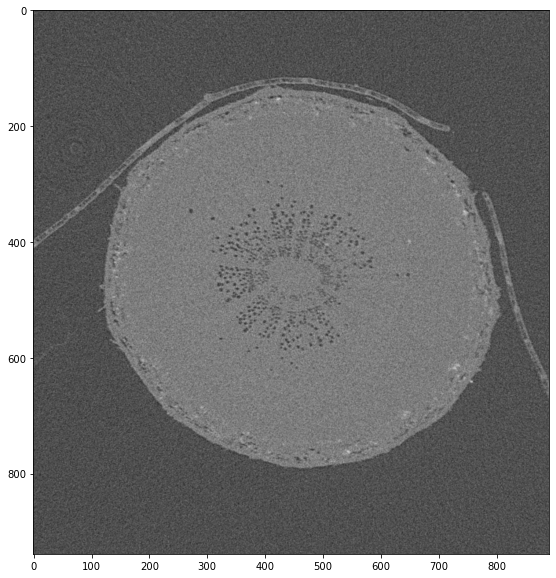

In [27]:


plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [38]:
# Get all image paths
# NB image file locations are /Volumes/PERL/invites/Session1|2/Living_plants/Analyzed/1_fs_07/slice00714.tif
imgs_pathnames = glob.glob('/Volumes/PERL/invites/*/*/Analyzed/*/*.tif')
imgs_pathnames

['/Volumes/PERL/invites/Session2/Living_Plants/Analyzed/1-qi-13/slice00840.tif',
 '/Volumes/PERL/invites/Session2/Living_Plants/Analyzed/1-qi-13/slice00698.tif',
 '/Volumes/PERL/invites/Session2/Living_Plants/Analyzed/1-qi-13/slice00728.tif',
 '/Volumes/PERL/invites/Session2/Living_Plants/Analyzed/1-qi-13/slice00767.tif',
 '/Volumes/PERL/invites/Session2/Living_Plants/Analyzed/1-qi-13/slice00799.tif',
 '/Volumes/PERL/invites/Session2/Living_Plants/Analyzed/1-qi-14/slice00730.tif',
 '/Volumes/PERL/invites/Session2/Living_Plants/Analyzed/1-qi-14/slice00796.tif',
 '/Volumes/PERL/invites/Session2/Living_Plants/Analyzed/1-qi-14/slice00847.tif',
 '/Volumes/PERL/invites/Session2/Living_Plants/Analyzed/1-qi-14/slice00967.tif',
 '/Volumes/PERL/invites/Session2/Living_Plants/Analyzed/1-qi-14/slice01134.tif',
 '/Volumes/PERL/invites/Session2/Living_Plants/Analyzed/1-qi-14/slice01171.tif',
 '/Volumes/PERL/invites/Session2/Living_Plants/Analyzed/1-qi-14/slice00685.tif',
 '/Volumes/PERL/invites/Sess

In [39]:
img_pathnames_df = pd.DataFrame(imgs_pathnames)
img_pathnames_df
DataFrame.to_csv

,0
0,/Volumes/PERL/invites/Session2/Living_Plants/A...
1,/Volumes/PERL/invites/Session2/Living_Plants/A...
2,/Volumes/PERL/invites/Session2/Living_Plants/A...
3,/Volumes/PERL/invites/Session2/Living_Plants/A...
4,/Volumes/PERL/invites/Session2/Living_Plants/A...
...,...
3275,/Volumes/PERL/invites/Session3/Flushed samples...
3276,/Volumes/PERL/invites/Session3/Flushed samples...
3277,/Volumes/PERL/invites/Session3/Flushed samples...
3278,/Volumes/PERL/invites/Session3/Flushed samples...


In [40]:
img_pathnames_df.to_scv("./img_pathnames_df.csv")

AttributeError: 'DataFrame' object has no attribute 'to_scv'

## ROI selection reconstruction into a mask

From the nicely formatted _ROI.csv and _emb.csv files, we want to create an image mask of the same number of pixels as the source image, which will be our mask.


In [ ]:

roi_csv_df = pd.read_csv(f"{}")
roi_mask_i = np.zeros((2, 3)) - 1